In [1]:
import os, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import cv2
import pickle



import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
print("Using TensorFlow:", tf.__version__)

Using TensorFlow: 2.16.2


In [2]:
data_path = "/Users/somita/Pharmaceutical Drugs Image Detection/Dataset/Drug Vision/Data Combined/"
img_size = 128
target_size = (img_size, img_size)
batch_size = 32

In [3]:
classes = os.listdir(data_path)  
print("Natural Directory Order:", classes)


Natural Directory Order: ['Decolgen', 'Fish Oil', 'Bactidol', 'Kremil S', 'Biogesic', 'DayZinc', 'Bioflu', 'Neozep', 'Alaxan', 'Medicol']


In [4]:
image_paths, labels = [], []
for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

image_paths, labels = np.array(image_paths), np.array(labels)


Decolgen : Class number 0, contains 1002 images


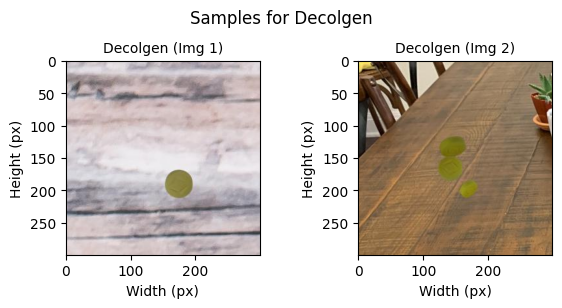

Fish Oil : Class number 1, contains 1002 images


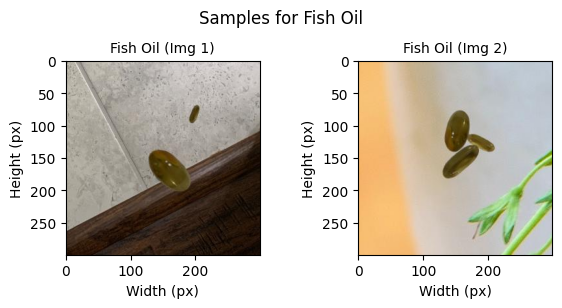

Bactidol : Class number 2, contains 1002 images


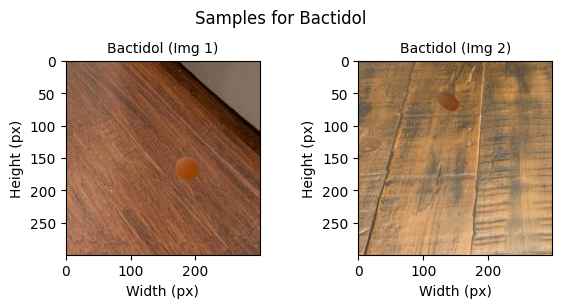

Kremil S : Class number 3, contains 1002 images


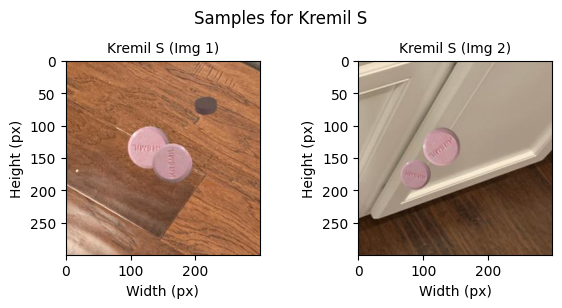

Biogesic : Class number 4, contains 1002 images


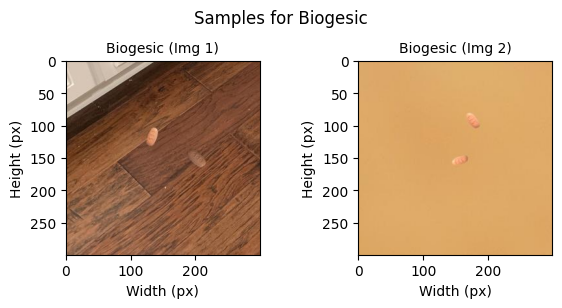

DayZinc : Class number 5, contains 1002 images


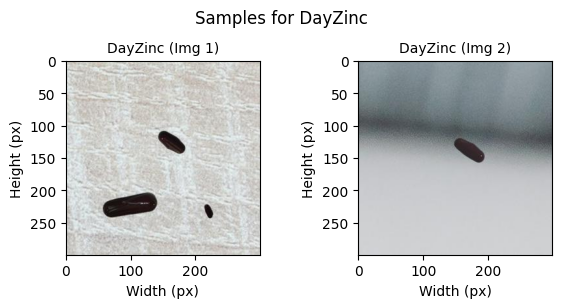

Bioflu : Class number 6, contains 1002 images


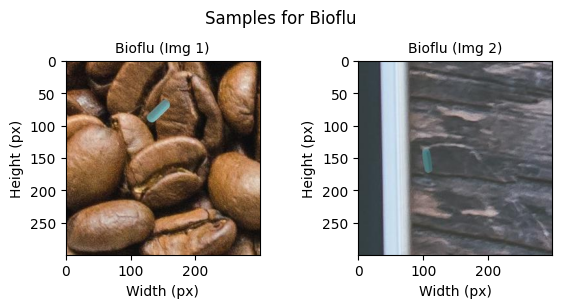

Neozep : Class number 7, contains 1002 images


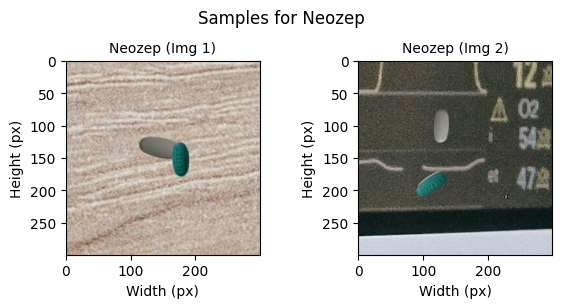

Alaxan : Class number 8, contains 1002 images


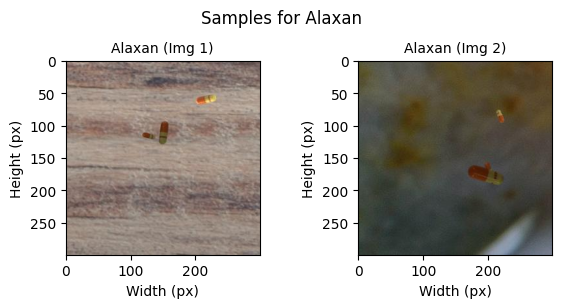

Medicol : Class number 9, contains 1002 images


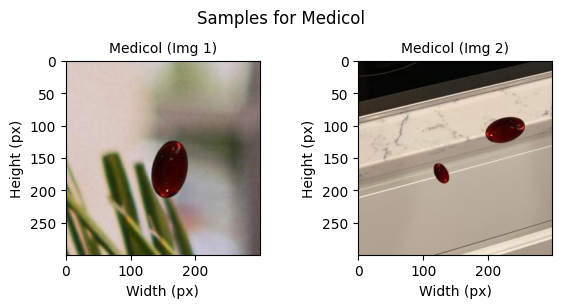

In [5]:
i = 0
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    img_files = os.listdir(class_path)

    print(f"{class_name} : Class number {i}, contains {len(img_files)} images")

    plt.figure(figsize=(6, 3))
    for j, img_file in enumerate(img_files[:2]):  
        img = cv2.imread(os.path.join(class_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 2, j+1)
        plt.imshow(img)
        plt.title(f"{class_name} (Img {j+1})", fontsize=10)
        plt.xlabel("Width (px)")
        plt.ylabel("Height (px)")
        plt.grid(False)  #
    plt.suptitle(f"Samples for {class_name}", fontsize=12)
    plt.tight_layout()
    plt.show()

    print("="*50)
    i += 1

In [6]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

train_df = pd.DataFrame({"filename": train_paths, "class": train_labels})
val_df = pd.DataFrame({"filename": val_paths, "class": val_labels})
test_df = pd.DataFrame({"filename": test_paths, "class": test_labels})

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=[0.7, 1.4],  
    shear_range=0.15,
    brightness_range=[0.85, 1.3],
    horizontal_flip=True,
    fill_mode="nearest"
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    classes=classes
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    classes=classes
)

print("\nFinal Class Mapping:", train_gen.class_indices)


Found 8016 validated image filenames belonging to 10 classes.
Found 1002 validated image filenames belonging to 10 classes.

Final Class Mapping: {'Decolgen': 0, 'Fish Oil': 1, 'Bactidol': 2, 'Kremil S': 3, 'Biogesic': 4, 'DayZinc': 5, 'Bioflu': 6, 'Neozep': 7, 'Alaxan': 8, 'Medicol': 9}


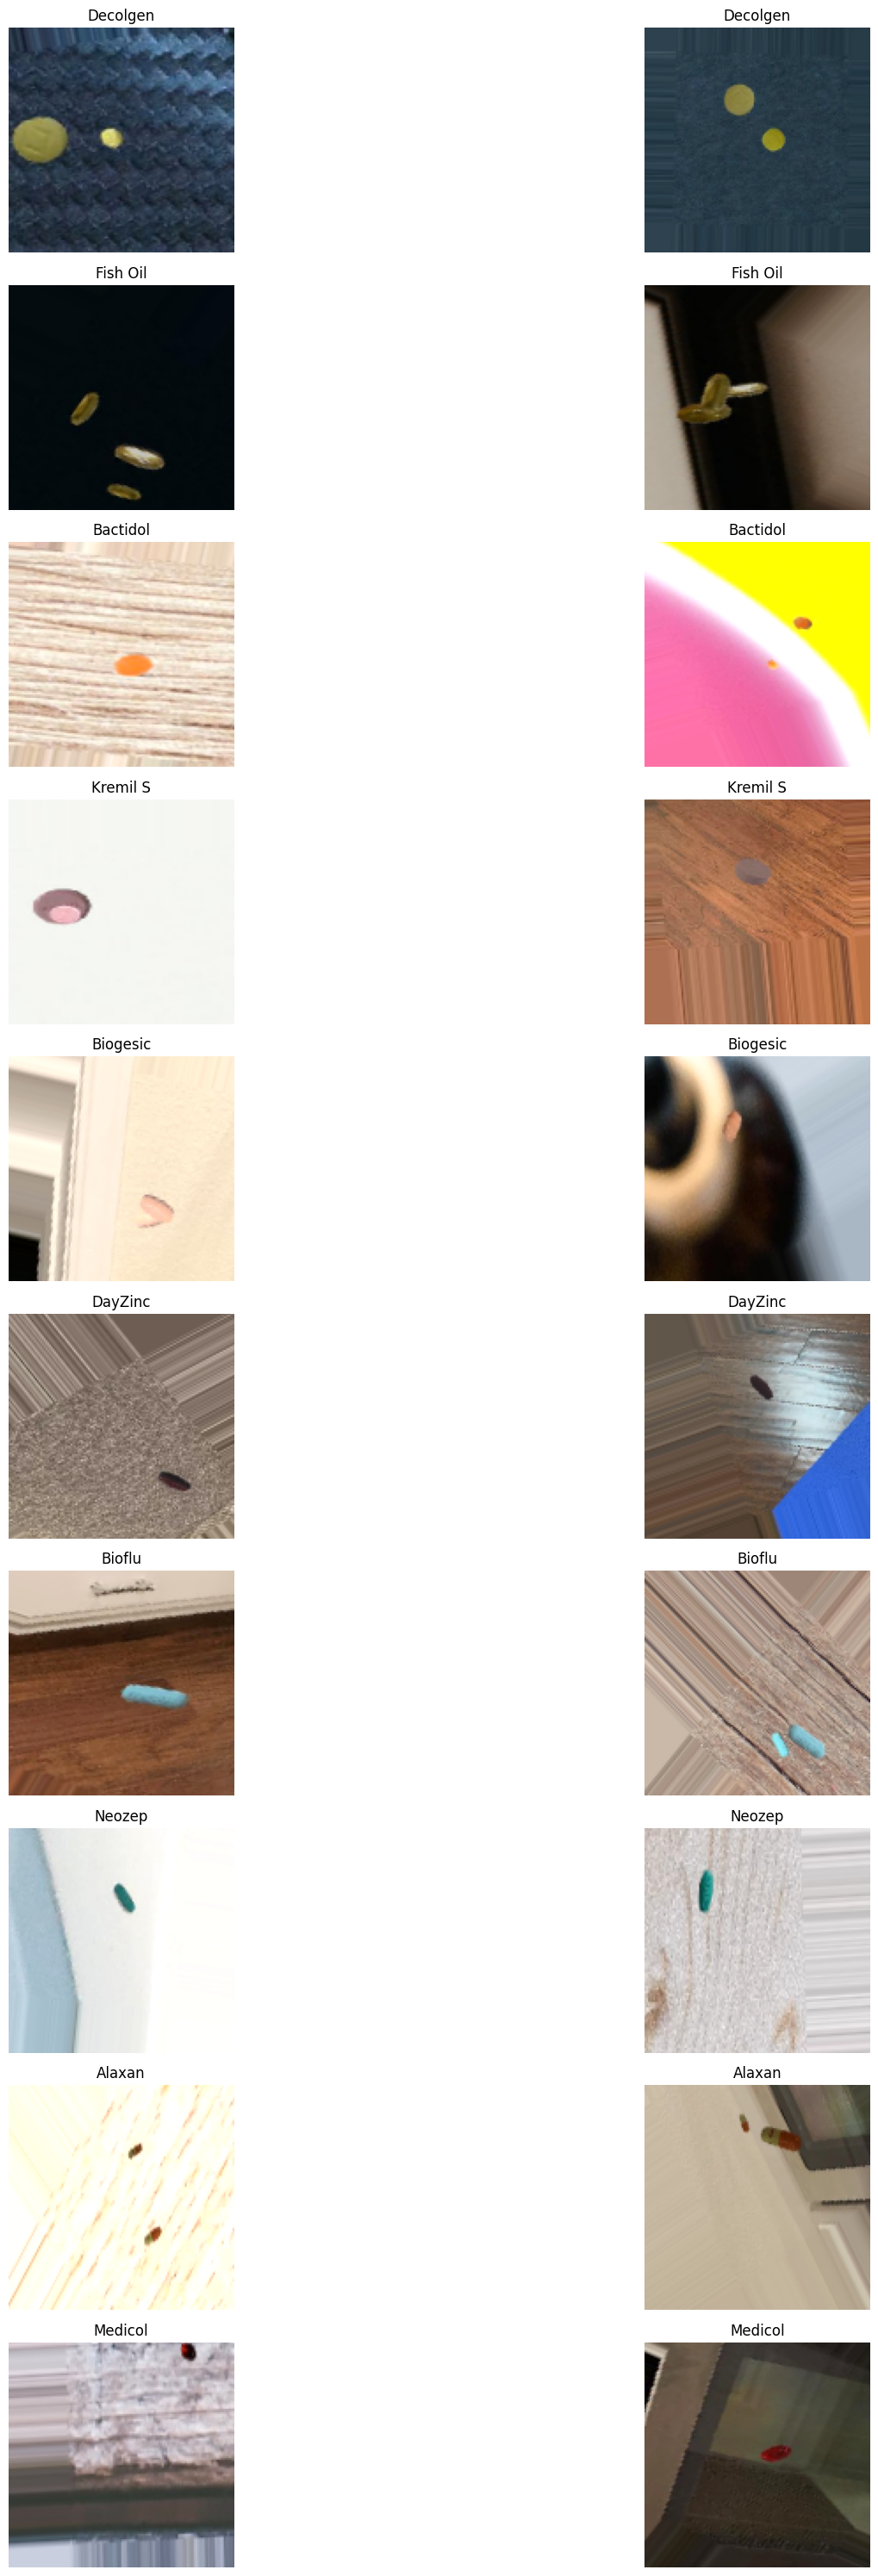

In [10]:
class_indices = train_gen.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}


class_counts = {class_name: 0 for class_name in inv_class_indices.values()}

sample_images = []
sample_labels = []


while min(class_counts.values()) < 2:
    imgs, labels = next(train_gen)
    for img, label in zip(imgs, labels):
        class_id = np.argmax(label)
        class_name = inv_class_indices[class_id]
        
        if class_counts[class_name] < 2:
            sample_images.append(img)
            sample_labels.append(class_name)
            class_counts[class_name] += 1
        
        if min(class_counts.values()) == 2:
            break


plt.figure(figsize=(20, len(class_indices) * 3))
plot_idx = 1

for class_name in class_indices.keys():
    for i in range(len(sample_labels)):
        if sample_labels[i] == class_name:
            plt.subplot(len(class_indices), 2, plot_idx)
            plt.imshow(sample_images[i])
            plt.title(class_name)
            plt.axis("off")
            plot_idx += 1

plt.tight_layout()
plt.show()

In [11]:
def create_model(trainable_ratio=0.0, lr=1e-4):
    base_model = EfficientNetB0(weights="imagenet", include_top=False,
                                input_shape=(img_size, img_size, 3))
    for layer in base_model.layers[int(len(base_model.layers) * trainable_ratio):]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(len(classes), activation="softmax")
    ])

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model



In [14]:
class TimeMetrics(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start = time.time()
        print(f"\nEpoch {epoch+1}/{self.params['epochs']} started...")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} completed in {time.time()-self.start:.2f} sec")
        print(f"Train Loss={logs['loss']:.4f}, Acc={logs['accuracy']:.4f}")
        print(f"Val Loss={logs['val_loss']:.4f}, Val Acc={logs['val_accuracy']:.4f}\n")
        time.sleep(120)

time_cb = TimeMetrics()
early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-7)

def save_all(model, history, name):
    model.save(f"{name}.keras")
    model.save_weights(f"{name}.weights.h5")
    with open(f"{name}_history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    print(f" Saved model, weights, and history as {name}")



In [15]:
model = create_model(trainable_ratio=0.0, lr=1e-4)
model.summary()

history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=9,  
    callbacks=[time_cb, early_stop, reduce_lr]
)

save_all(model, history_stage1, "pill_stage1")
print("\n Stage 1 Training Completed and Saved\n")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 4,338,054 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)


Epoch 1/9 started...
Epoch 1/9
Epoch 1 completed in 363.35 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.1921 - loss: 2.2832  
Train Loss=1.9593, Acc=0.3056
Val Loss=2.3209, Val Acc=0.1267

251/251 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.1925 - loss: 2.2819 - val_accuracy: 0.1267 - val_loss: 2.3209 - learning_rate: 1.0000e-04

Epoch 2/9 started...
Epoch 2/9
Epoch 2 completed in 328.47 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.5675 - loss: 1.1889  
Train Loss=1.0911, Acc=0.6018
Val Loss=1.8955, Val Acc=0.3483

251/251 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.5676 - loss: 1.1885 - val_accuracy: 0.3483 - val_loss: 1.8955 - learning_rate: 1.0000e-04

Epoch 3/9 started...
Epoch 3/9
Epoch 3 completed in 313.69 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.6959 - loss: 0.8454  
Train Loss=0.8323, Acc=0.7001
Val Loss=2.8279, Val Acc=0.1657

251/251 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.6960 - loss: 0.8454 - val_accuracy: 0.1657 - val_loss: 2.8279 - learning_rate: 1.0000e-04

Epoch 4/9

In [17]:
for layer in model.layers[0].layers[int(len(model.layers[0].layers) * 0.6):]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy", metrics=["accuracy"])

history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=9,
    callbacks=[time_cb, early_stop, reduce_lr]
)

save_all(model, history_stage2, "pill_stage2")


print("\n Stage 2 Training Completed and Saved\n")


Epoch 1/9 started...
Epoch 1/9
Epoch 1 completed in 499.79 sec━━━━━━━━━━ 0s 2s/step - accuracy: 0.7882 - loss: 0.5943   
Train Loss=0.6121, Acc=0.7849
Val Loss=0.5794, Val Acc=0.7924

251/251 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.7881 - loss: 0.5943 - val_accuracy: 0.7924 - val_loss: 0.5794 - learning_rate: 1.0000e-05

Epoch 2/9 started...
Epoch 2/9
Epoch 2 completed in 577.26 sec━━━━━━━━━━ 0s 2s/step - accuracy: 0.7842 - loss: 0.6172  
Train Loss=0.6033, Acc=0.7871
Val Loss=0.9246, Val Acc=0.6417

251/251 ━━━━━━━━━━━━━━━━━━━━ 697s 3s/step - accuracy: 0.7842 - loss: 0.6171 - val_accuracy: 0.6417 - val_loss: 0.9246 - learning_rate: 1.0000e-05

Epoch 3/9 started...
Epoch 3/9
Epoch 3 completed in 377.29 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.7814 - loss: 0.6016  
Train Loss=0.5960, Acc=0.7857
Val Loss=0.4246, Val Acc=0.8523

251/251 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.7814 - loss: 0.6016 - val_accuracy: 0.8523 - val_loss: 0.4246 - learning_rate: 1.0000e-05

Epoch 4/

In [18]:
for layer in model.layers[0].layers:
    layer.trainable = True  


model.compile(
    optimizer=Adam(learning_rate=5e-6),  
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nStage 3 – Full Fine-Tuning Model Summary:\n")
model.summary()


Stage 3 – Full Fine-Tuning Model Summary:



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 4,338,054 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [19]:
history_stage3 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12, 
    callbacks=[time_cb, early_stop, reduce_lr]
)


model.save("pill_stage3.keras")
model.save_weights("pill_stage3.weights.h5")

with open("pill_stage3_history.pkl", "wb") as f:
    pickle.dump(history_stage3.history, f)

print("\n Stage 3 Training Completed – Model, Weights, and History Saved\n")


Epoch 1/12 started...
Epoch 1/12
Epoch 1 completed in 525.09 sec━━━━━━━━━━ 0s 2s/step - accuracy: 0.8035 - loss: 0.5352   
Train Loss=0.5395, Acc=0.8060
Val Loss=0.3826, Val Acc=0.8713

251/251 ━━━━━━━━━━━━━━━━━━━━ 645s 2s/step - accuracy: 0.8035 - loss: 0.5352 - val_accuracy: 0.8713 - val_loss: 0.3826 - learning_rate: 5.0000e-06

Epoch 2/12 started...
Epoch 2/12
Epoch 2 completed in 319.14 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.7937 - loss: 0.5755  
Train Loss=0.5592, Acc=0.7992
Val Loss=0.3331, Val Acc=0.8882

251/251 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.7937 - loss: 0.5754 - val_accuracy: 0.8882 - val_loss: 0.3331 - learning_rate: 5.0000e-06

Epoch 3/12 started...
Epoch 3/12
Epoch 3 completed in 315.18 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.8146 - loss: 0.5314  
Train Loss=0.5328, Acc=0.8170
Val Loss=0.4025, Val Acc=0.8623

251/251 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.8146 - loss: 0.5314 - val_accuracy: 0.8623 - val_loss: 0.4025 - learning_rate: 5.0000e-06

Ep

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step 

Classification Report:

              precision    recall  f1-score   support

    Decolgen       0.96      0.89      0.92       100
    Fish Oil       0.85      0.93      0.89       100
    Bactidol       0.98      0.82      0.89       100
    Kremil S       0.97      0.97      0.97       100
    Biogesic       0.88      0.91      0.90       100
     DayZinc       0.94      0.97      0.96       101
      Bioflu       0.91      0.90      0.90       100
      Neozep       0.91      0.85      0.88       101
      Alaxan       0.78      0.88      0.83       100
     Medicol       0.96      0.97      0.97       100

    accuracy                           0.91      1002
   macro avg       0.91      0.91      0.91      1002
weighted avg       0.91      0.91      0.91      1002



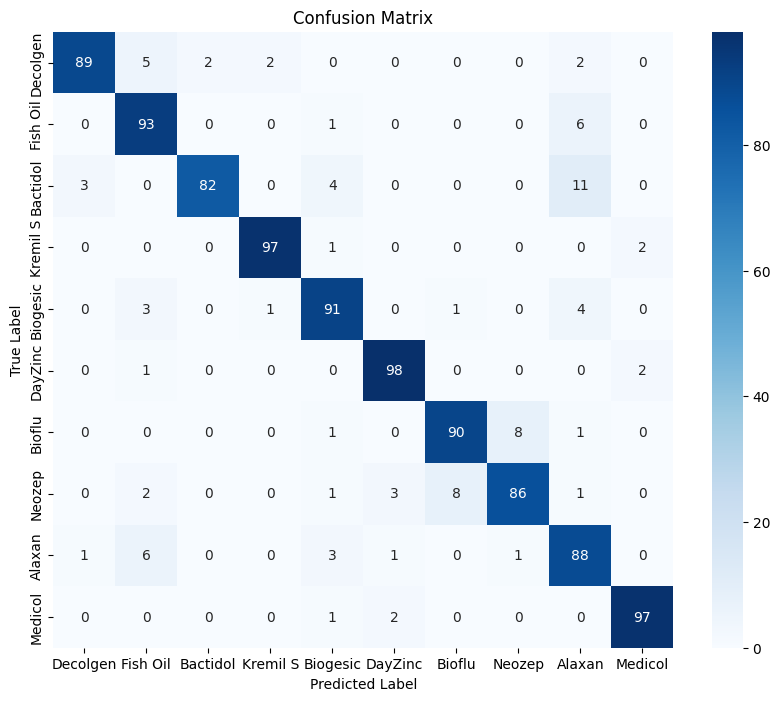

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


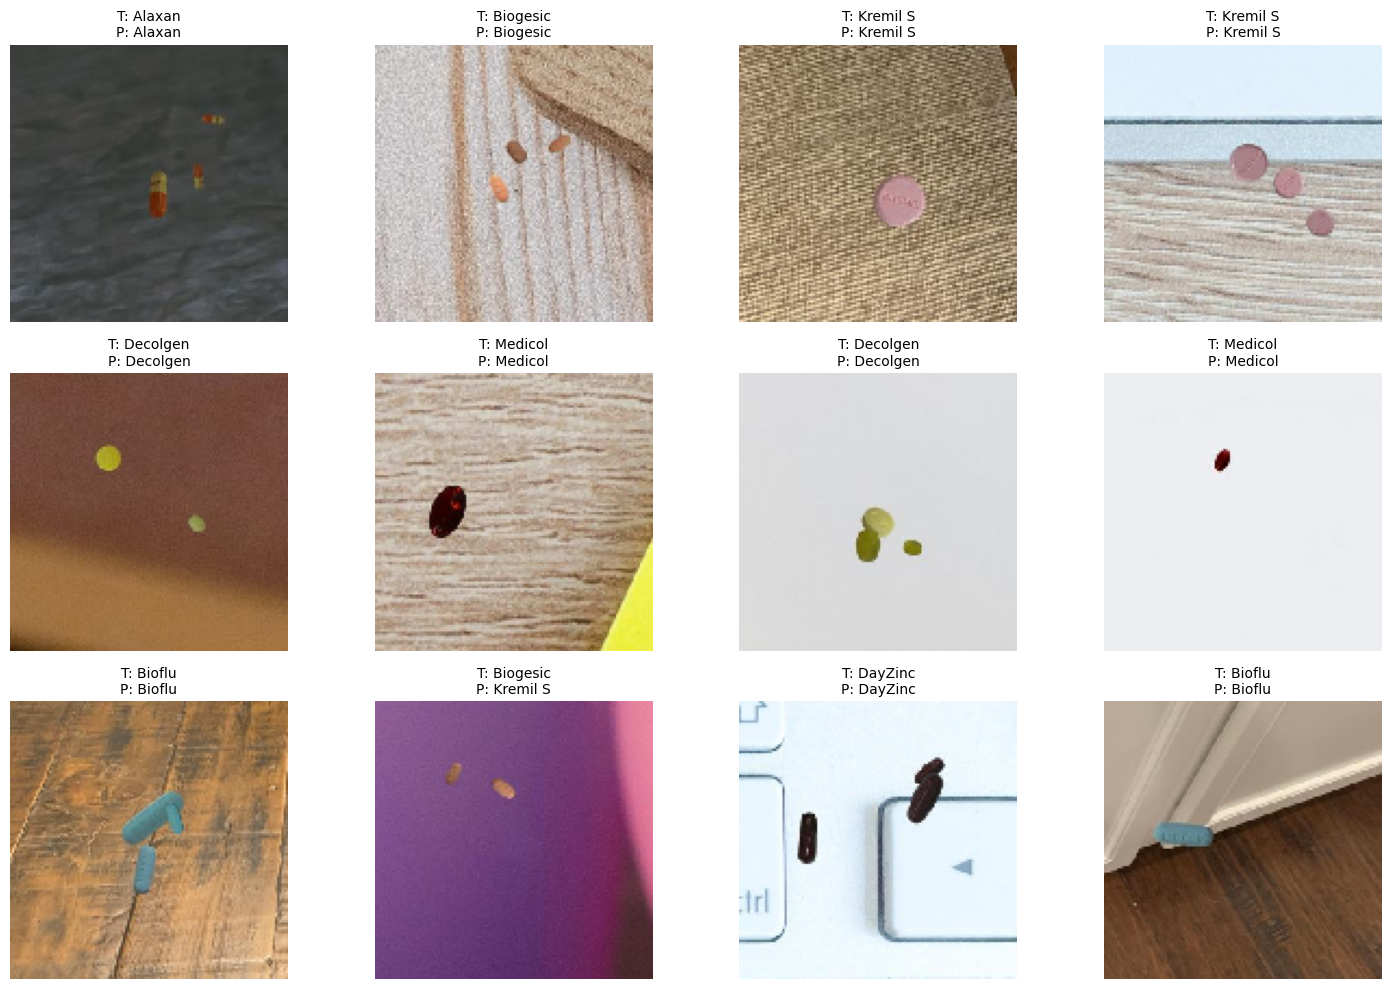

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_gen.reset()

# Predictions
pred_probs = model.predict(val_gen, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# OVERALL REPORT 
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# CONFUSION MATRIX
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Sample
sample_images, sample_labels = next(val_gen)
pred_sample = model.predict(sample_images)
pred_labels = np.argmax(pred_sample, axis=1)

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_labels[np.argmax(sample_labels[i])]
    pred_label = class_labels[pred_labels[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
for layer in model.layers[0].layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=2e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nStage 4 – Final Fine-Tuning Model Summary:\n")
model.summary()


Stage 4 – Final Fine-Tuning Model Summary:



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 4,338,054 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [27]:
history_stage4 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,  
    callbacks=[time_cb, early_stop, reduce_lr]
)


model.save("pill_classifier_stage4.keras")
model.save_weights("pill_classifier_stage4.weights.h5")

import pickle
with open("pill_classifier_stage4_history.pkl", "wb") as f:
    pickle.dump(history_stage4.history, f)

print("\n Stage 4 Training Completed – Model, Weights & History Saved\n")


Epoch 1/12 started...
Epoch 1/12
Epoch 1 completed in 320.70 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.8141 - loss: 0.5205  
Train Loss=0.5155, Acc=0.8145
Val Loss=0.2787, Val Acc=0.9072

251/251 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.8141 - loss: 0.5205 - val_accuracy: 0.9072 - val_loss: 0.2787 - learning_rate: 2.0000e-06

Epoch 2/12 started...
Epoch 2/12
Epoch 2 completed in 311.52 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.8164 - loss: 0.5152  
Train Loss=0.5225, Acc=0.8140
Val Loss=0.2884, Val Acc=0.9062

251/251 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8164 - loss: 0.5152 - val_accuracy: 0.9062 - val_loss: 0.2884 - learning_rate: 2.0000e-06

Epoch 3/12 started...
Epoch 3/12
Epoch 3 completed in 316.95 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.8192 - loss: 0.5153  
Train Loss=0.5219, Acc=0.8151
Val Loss=0.2857, Val Acc=0.9112

251/251 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.8192 - loss: 0.5154 - val_accuracy: 0.9112 - val_loss: 0.2857 - learning_rate: 2.0000e-06

Epo

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step

Classification Report:
              precision    recall  f1-score   support

    Decolgen       0.96      0.93      0.94       100
    Fish Oil       0.86      0.95      0.90       100
    Bactidol       0.95      0.83      0.89       100
    Kremil S       0.98      0.97      0.97       100
    Biogesic       0.89      0.91      0.90       100
     DayZinc       0.94      0.97      0.96       101
      Bioflu       0.91      0.88      0.89       100
      Neozep       0.89      0.85      0.87       101
      Alaxan       0.81      0.88      0.85       100
     Medicol       0.96      0.97      0.97       100

    accuracy                           0.91      1002
   macro avg       0.92      0.91      0.91      1002
weighted avg       0.92      0.91      0.91      1002



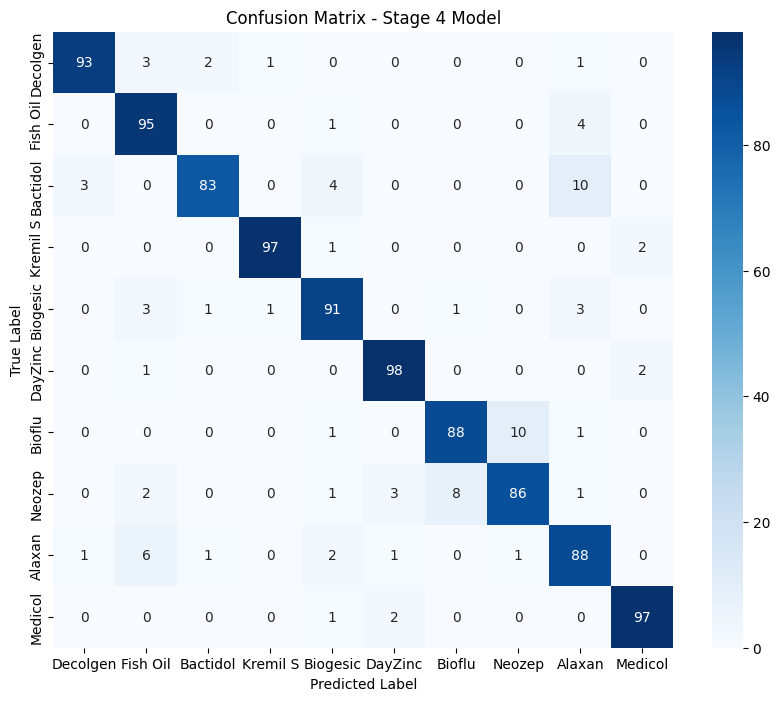

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reset val_gen before predicting
val_gen.reset()
predictions = model.predict(val_gen, verbose=1)

y_true = val_gen.classes
y_pred = np.argmax(predictions, axis=1)

class_labels = list(val_gen.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Stage 4 Model")
plt.show()


In [30]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=5e-7),  
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_stage4_retrain = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12, 
    callbacks=[time_cb, early_stop, reduce_lr]
)

model.save("pill_classifier_stage4_retrain.keras")
model.save_weights("pill_classifier_stage4_retrain.weights.h5")

import pickle
with open("pill_classifier_stage4_retrain_history.pkl", "wb") as f:
    pickle.dump(history_stage4_retrain.history, f)

print("\n Stage 4 Retraining Completed – Model, Weights & History Saved\n")



Epoch 1/12 started...
Epoch 1/12
Epoch 1 completed in 504.27 sec━━━━━━━━━━ 0s 2s/step - accuracy: 0.8083 - loss: 0.5267   
Train Loss=0.5232, Acc=0.8129
Val Loss=0.2739, Val Acc=0.9062

251/251 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.8083 - loss: 0.5267 - val_accuracy: 0.9062 - val_loss: 0.2739 - learning_rate: 5.0000e-07

Epoch 2/12 started...
Epoch 2/12
Epoch 2 completed in 327.82 sec━━━━━━━━━━ 0s 1s/step - accuracy: 0.8251 - loss: 0.4964  
Train Loss=0.5050, Acc=0.8217
Val Loss=0.2741, Val Acc=0.9062

251/251 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.8251 - loss: 0.4964 - val_accuracy: 0.9062 - val_loss: 0.2741 - learning_rate: 5.0000e-07

Epoch 3/12 started...
Epoch 3/12
Epoch 3 completed in 391.09 sec━━━━━━━━━━ 0s 2s/step - accuracy: 0.8096 - loss: 0.5414  
Train Loss=0.5316, Acc=0.8123
Val Loss=0.2712, Val Acc=0.9072

251/251 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.8096 - loss: 0.5413 - val_accuracy: 0.9072 - val_loss: 0.2712 - learning_rate: 5.0000e-07

Ep

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step  

 Overall Accuracy: 91.22%
 Top‑3 Accuracy: 98.20%

 Classification Report:

              precision    recall  f1-score   support

    Decolgen       0.96      0.93      0.94       100
    Fish Oil       0.86      0.95      0.90       100
    Bactidol       0.94      0.83      0.88       100
    Kremil S       0.98      0.97      0.97       100
    Biogesic       0.91      0.89      0.90       100
     DayZinc       0.94      0.97      0.96       101
      Bioflu       0.91      0.88      0.89       100
      Neozep       0.89      0.85      0.87       101
      Alaxan       0.79      0.88      0.83       100
     Medicol       0.96      0.97      0.97       100

    accuracy                           0.91      1002
   macro avg       0.91      0.91      0.91      1002
weighted avg       0.91      0.91      0.91      1002



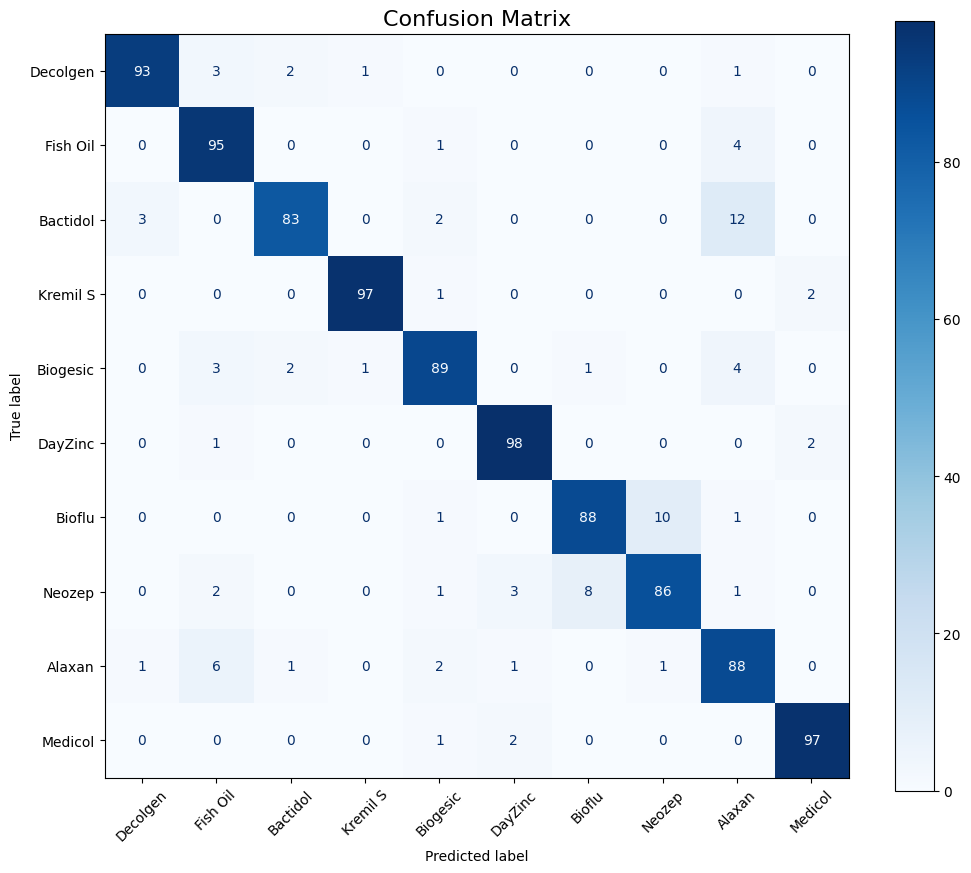

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


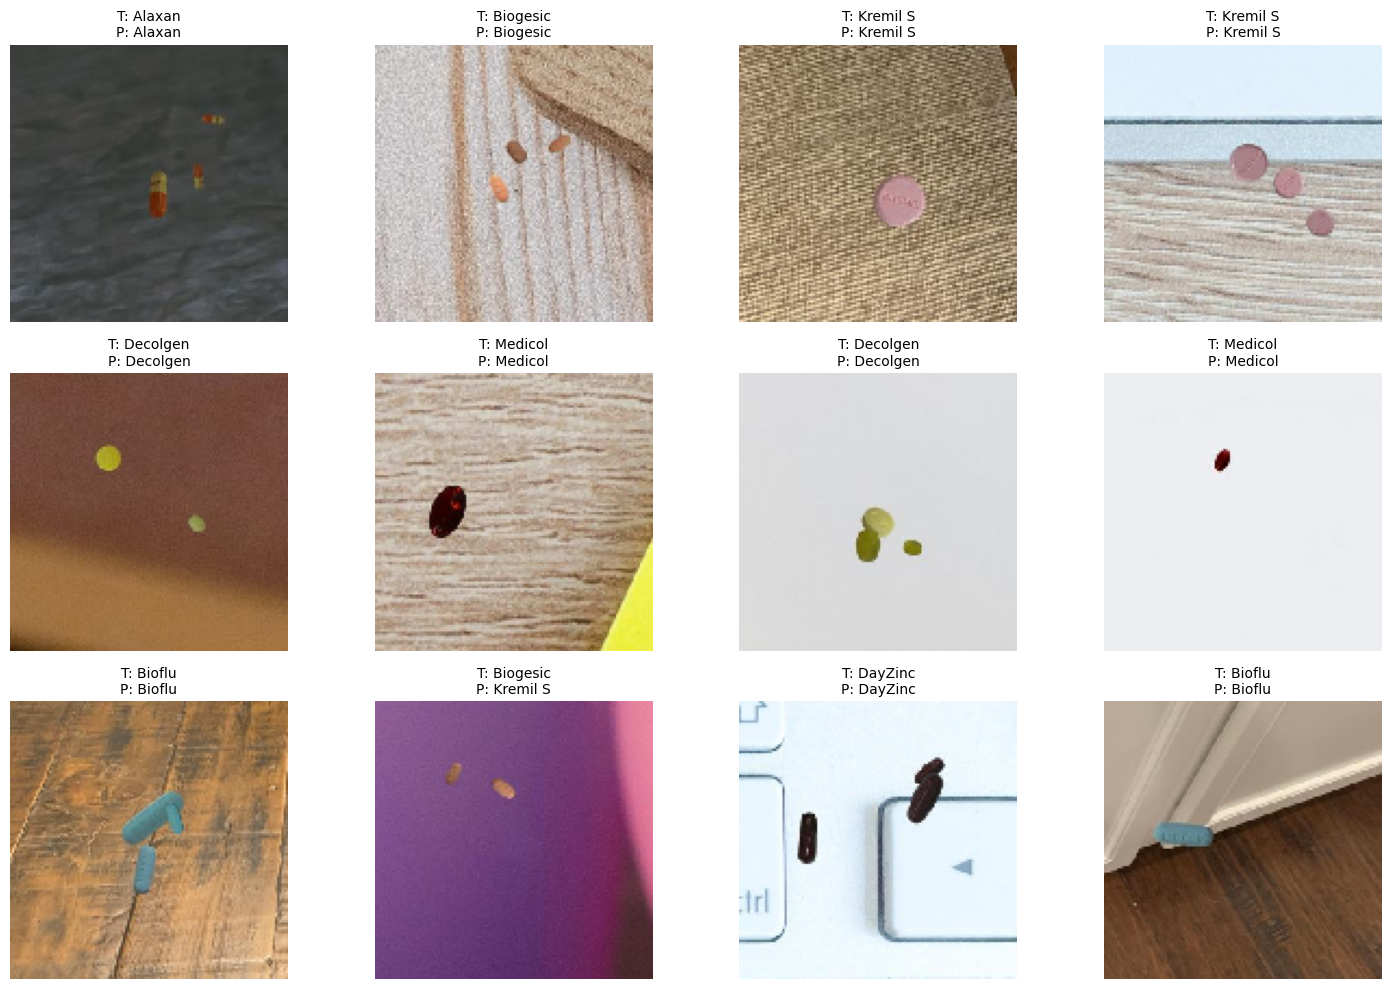

In [33]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


val_gen.reset()


pred_probs = model.predict(val_gen, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())


accuracy = np.mean(pred_classes == true_classes)
print(f"\n Overall Accuracy: {accuracy*100:.2f}%")


top3_preds = np.argsort(pred_probs, axis=1)[:, -3:]
top3_correct = np.array([true_classes[i] in top3_preds[i] for i in range(len(true_classes))])
top3_acc = np.mean(top3_correct)
print(f" Top‑3 Accuracy: {top3_acc*100:.2f}%")


print("\n Classification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix", fontsize=16)
plt.show()


sample_images, sample_labels = next(val_gen)
pred_sample = model.predict(sample_images)
pred_labels = np.argmax(pred_sample, axis=1)

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_labels[np.argmax(sample_labels[i])]
    pred_label = class_labels[pred_labels[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()